# Evaluating Models
## 1. Introduction
In this notebook, we do a very basic evaluation of each model against a manually generated dataset.
We will compare:
- BinaryNet
- XNOR-NET
- ABCNet

## 2. Generating Data
### 2.1 Function
We will choose a quadratic function:
$$
  F(x)=ax^2+bx+c
$$
### 2.2 Parameters
We will set:
- $a=2$
- $b=3$
- $c=2$

### 2.3 Data
1. We will generate $n=20000$ samples $X_1,\dots,X_n$ from the uniform distribution $\mathcal{U}(-4,4)$
2. We will generate $n=20000$ samples $\epsilon_1,\dots,\epsilon_n$ from the normal distribution $\mathcal{N}(0,\sigma),$ with $\sigma=0.1$
3. We will calculate $y_1,\dots,y_n$ as:
    $$
    y_i=aX_i^2+bX_i+c+\epsilon_i
    $$

In [10]:
import tensorflow as tf
import larq as lq
import numpy as np
from binaryflow import quantizers,layers
from sklearn.model_selection import train_test_split
from binaryflow.layers.XnorNet import *
from binaryflow.layers.ABCNet import *
from binaryflow.layers.BinaryNet import *
from binaryflow.block.BiRealNet import *


a=2
b=3
c=2
n=20000
std=0.1
np.random.seed(21)
tf.random.set_seed(27)
X=np.random.uniform(-4,4,[n,1])
err=np.random.normal(0,std,[n,1])
y=a*X**2+b*X+c+err
def F(x):
    return a*x**2+b*x+c

## 3. Creating Models

In [11]:
binarynet_args = dict(
    kernel_quantizer="ste_sign",
    input_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    #kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

xnornet_args = dict(
    kernel_quantizer="ste_sign",
    input_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    #kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False,
    alpha_trainable=True
)

abcnet_args = dict(
    kernel_estimators=3,
    kernel_quantizers=quantizers.ShiftedSteSign,
    input_quantizers=quantizers.ShiftedSteSign,
    kernel_constraint="weight_clip",
    kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

mlp_args={}

X_train,X_test,y_train,y_test=train_test_split(X,y)


models={}
noisy_models={}
model_names=["BinaryNet","XNOR-NET","ABCNet","MLP"]
model_layers={"BinaryNet":lq.layers.QuantDense,"XNOR-NET":ScaledQuantDense,"ABCNet":ABCDense,"MLP":tf.keras.layers.Dense}

for name,kwargs in zip(model_names,[binarynet_args,xnornet_args,abcnet_args,mlp_args]):
    Dense=model_layers[name]
    layers=[tf.keras.layers.Dense(24),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(24,activation="relu", **kwargs),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(24,activation="relu", **kwargs),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(1, **kwargs)]
    models[name]=tf.keras.models.Sequential(layers)
    noisy_models[name]=tf.keras.models.Sequential([
        tf.keras.layers.GaussianNoise(stddev=.5),
        *layers
    ])


## 4. Fitting Models

In [12]:

for model_family in [models]:
    for model in model_family.values():
        model.compile(
            tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
            loss="mean_squared_error"
        )
        model.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=29,
            validation_data=(X_test, y_test),
            shuffle=True
        )

Epoch 1/29


/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


118/118 [==============================] - 2s 7ms/step - loss: 119.5828 - val_loss: 85.9359
Epoch 2/29
118/118 [==============================] - 1s 6ms/step - loss: 69.6147 - val_loss: 198.9307
Epoch 3/29
118/118 [==============================] - 1s 7ms/step - loss: 53.0703 - val_loss: 155.2230
Epoch 4/29
118/118 [==============================] - 1s 7ms/step - loss: 47.7718 - val_loss: 107.0324
Epoch 5/29
118/118 [==============================] - 1s 8ms/step - loss: 44.9449 - val_loss: 167.4443
Epoch 6/29
118/118 [==============================] - 1s 7ms/step - loss: 43.9556 - val_loss: 155.6160
Epoch 7/29
118/118 [==============================] - 1s 8ms/step - loss: 41.8557 - val_loss: 185.2397
Epoch 8/29
118/118 [==============================] - 1s 7ms/step - loss: 42.0349 - val_loss: 261.9566
Epoch 9/29
118/118 [==============================] - 1s 8ms/step - loss: 40.5298 - val_loss: 285.9961
Epoch 10/29
118/118 [==============================] - 1s 6ms/step - loss: 39.2867 -

## 5. Plotting Boundaries

32/32 [==============================] - 0s 2ms/step


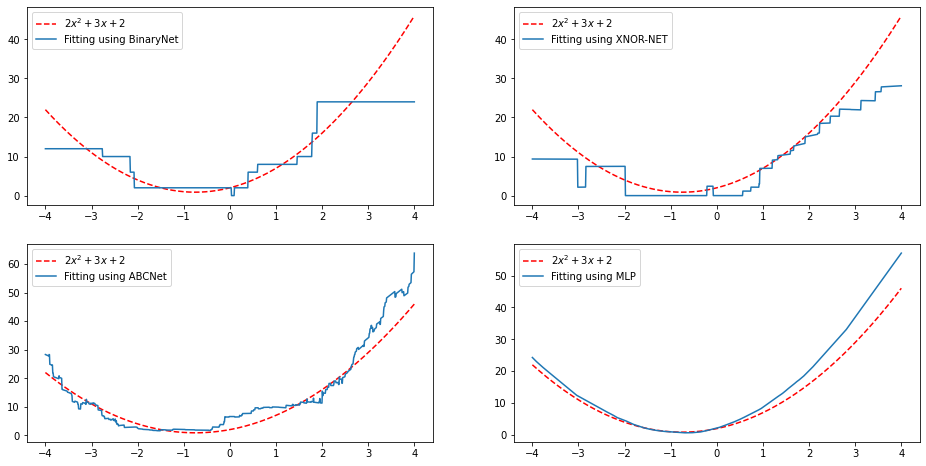

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tck
fig,axs=plt.subplots(2,2,figsize=(16,8))
def plot_models(X,models,axs=None):
    names=[]
    for name in models:
        names.append(name)
    for i,axz in enumerate(axs):
        for j ,ax in enumerate(axz):
            sns.lineplot(x=U,y=a*U**2+b*U+c,ax=ax,label=f"${a}x^2+{b}x+{c}$",color="red",linestyle='--')
            name=names[2*i+j]
            sns.lineplot(x=U,y=models[name].predict(U.reshape((-1,1))).reshape((-1,)),ax=ax,label=f"Fitting using {name}")
            ax.tick_params(which="both", bottom=True)

m=1000
U=np.linspace(-4,4,m)
plot_models(U,models,axs)
#axs.set_title("Comparison between models predictions")
fig.savefig("local/model-performances-quadratic2.svg")

## 6. Distribution of parameters

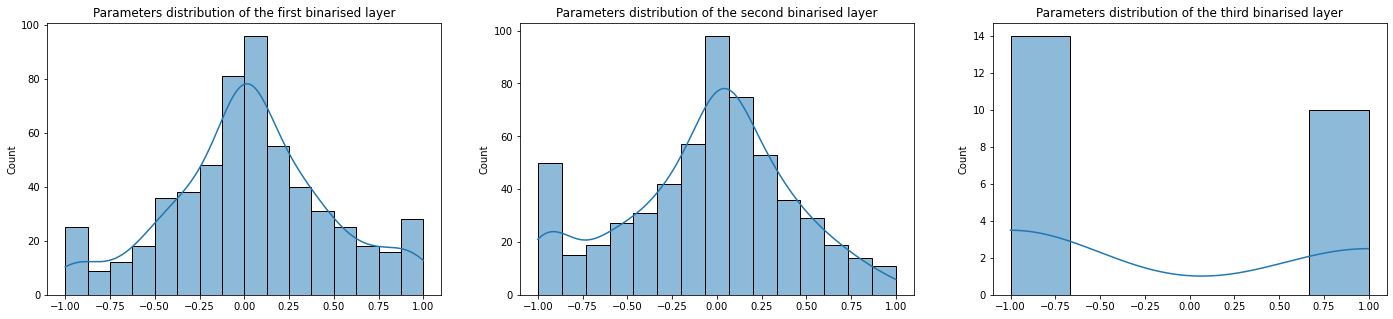

In [22]:
W=[models["BinaryNet"].layers[2*i+2].kernel for i in range(3)]
def count_name(n):
    if n==1:
        return "first"
    if n==2:
        return "second"
    if n==3:
        return "third"


fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.numpy().flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} binarised layer")
fig.savefig("parameters-distribution-xnor-net.svg")

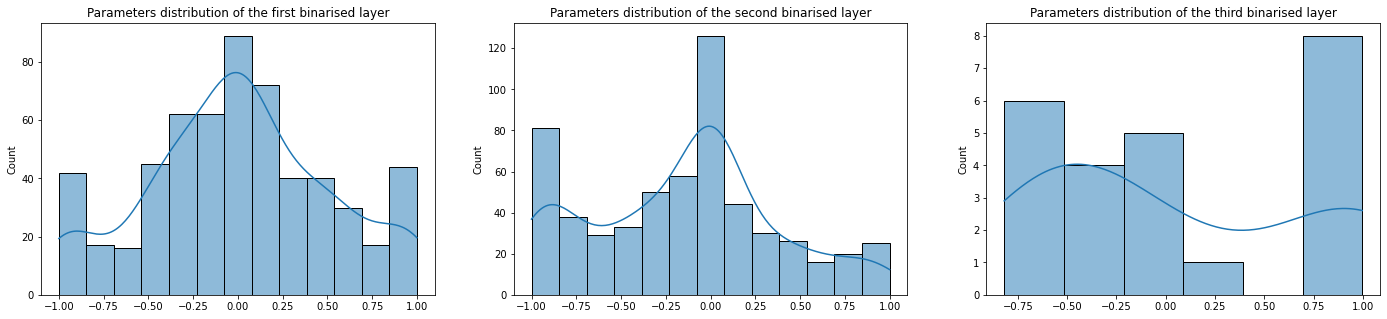

In [14]:
W=[models["XNOR-NET"].layers[2*i+2].kernel for i in range(3)]

fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.numpy().flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} binarised layer")
fig.savefig("parameters-distribution-xnor-net.svg")

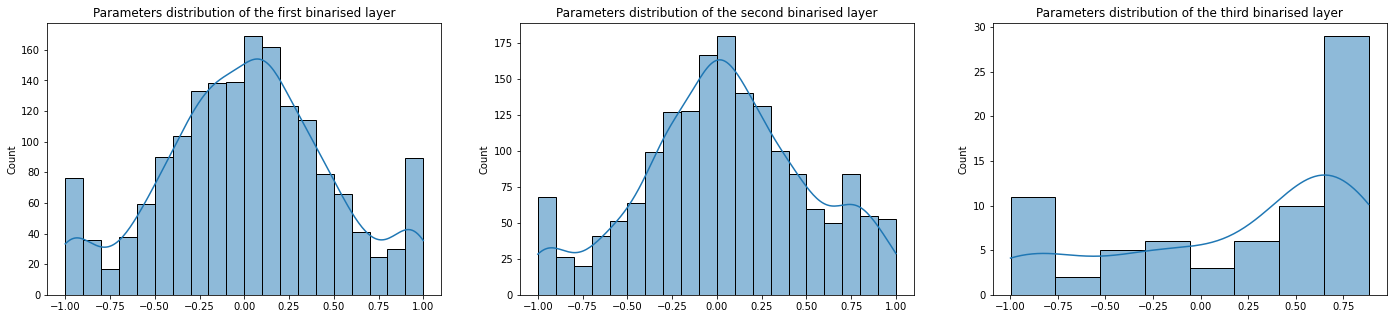

In [15]:
W=[np.array([estimator.kernel for estimator in models["ABCNet"].layers[2*i+2].estimators]) for i in range(3)]
fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} binarised layer")
fig.savefig("local/parameters-distribution-abc-net.svg")

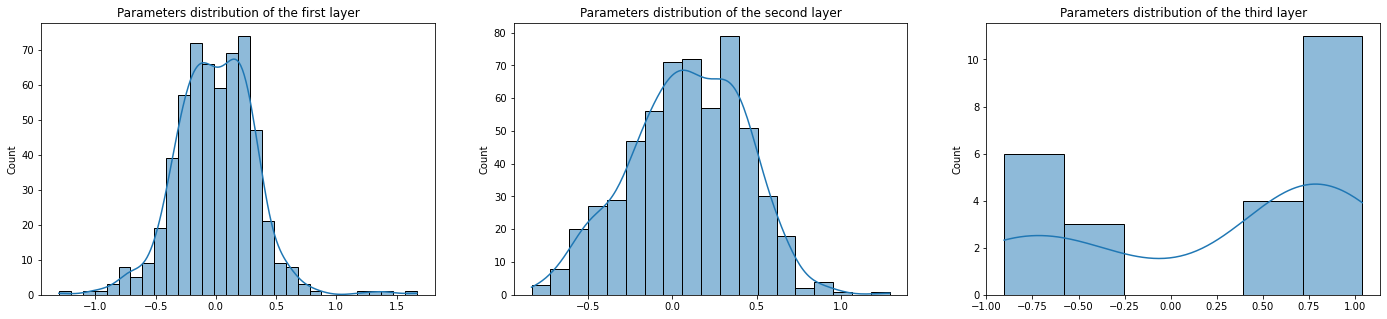

In [20]:
W=[models["MLP"].layers[2*i+2].kernel for i in range(3)]
fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.numpy().flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} layer")
fig.savefig("local/parameters-distribution-abc-net.svg")

## 7. Performance Test
We will mesure the model's performance using the squared $\mathcal{L}^2$ distance of the $\mathcal{C}([-4,4])$ space:
$$
  \mathcal{L}(F,\mathcal{M}_\theta)=\int_{-4}^4(M_\theta-F)^2d\mu = \int_{-4}^4 (M_\theta(x)-F(x))^2dx
$$

In [23]:
import scipy.integrate as integrate
n=2**20+1
samples=np.linspace(-4,4,n)
errors=[]
for name in models:
    row=[]
    model=models[name]
    row.append(name)
    err=np.abs(model(samples).numpy().flatten()-F(samples))
    row.append(np.max(err))
    for k in [1,2]:
        row.append(integrate.romb(err**k,dx=1/n))
    errors.append(row)
errors=pd.DataFrame(errors,columns=["Method","$\mathcal{L}^\infty$","$\mathcal{L}^1$","$\mathcal{L}^2$ Squared"])
errors["$\mathcal{L}^2$"]=np.sqrt(errors["$\mathcal{L}^2$ Squared"])
errors

,Method,$\mathcal{L}^\infty$,$\mathcal{L}^1$,$\mathcal{L}^2$ Squared,$\mathcal{L}^2$
0,BinaryNet,22.000000,3.655195,33.353148,5.775218
1,XNOR-NET,17.885567,3.807591,29.378610,5.420204
2,ABCNet,17.863966,2.941291,17.142549,4.140356
3,MLP,11.026714,2.846293,18.619267,4.315005


## 8. Saving Models

In [54]:
for name in models:
    models[name].save(f"trained/{name}Regression")

ValueError: Unable to create dataset (name already exists)